# Project Setup

In [1]:
#  load necessary packages
import pandas as pd 
from pandas import MultiIndex, Int16Dtype
from ucimlrepo import fetch_ucirepo 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import warnings
from scipy.stats import chi2_contingency
from flaml import AutoML
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score


In [2]:
warnings.filterwarnings("ignore")

# Project Topic

#### Project Explanation

This project is a supervised machine learning problem. This will be a classification task as I will be predicting whether a given mushroom is edible or inedible (poisinous or not).

#### Project Goal

This project aims to classify mushrooms as edible or inedible. 

I find the topic interesting as I often encounter mushrooms in my outdoor adventures. Over the course of the project, I aim to hone key skills in machine learning such as feature engineering, extracting relevant features, implementing machine learning algorithms, and hyperparameter tuning.

# Data

#### Data Citation

This dataset is from the UC Irvine machine learning repository. You can access the data through the link here https://archive.ics.uci.edu/dataset/73/mushroom and below is a citation.

Mushroom. (1987). UCI Machine Learning Repository. https://doi.org/10.24432/C5959T

#### Data Description

In [3]:
# load the data set (it is part of the UC Irvine ML Repo so I can call it from the package loaded above
mushroom = fetch_ucirepo(id=73)

# lets see what it looks like
x = pd.DataFrame(mushroom.data.features) # extract features
y = pd.DataFrame(mushroom.data.targets) # extract targets

# concatenate target and features into a single dataset
df = pd.concat([x, y], axis=1)

In [4]:
# just taking a look at the data
df.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e


In [5]:
# distribution of edible vs inedible features
y.value_counts()

poisonous
e            4208
p            3916
Name: count, dtype: int64

The distribution of edible to poisoninous plants is relatively even which will most likely allow me to avoid any resampling techniques later on.

In [6]:
# information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                5644 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

There are 22 predictive features in this data set and they are all categorical. One key note is that there are less non-null values in the "stalk-root" field so I will have to either remove that feature or impute the values later on. 

In [7]:
# shape of the data
print(f"This dataset is {len(df)} rows long and contains {x.shape[1]} features excluding the target variable.")

This dataset is 8124 rows long and contains 22 features excluding the target variable.


# Data Cleaning

#### 1. Missing Values

In [8]:
# determining the values that need imputed

missing_values = pd.DataFrame(columns=['Column', 'pct_missing']) # create empty data frame to store values

# Loop through each column and calculate the percentage of NaN values
for column in df.columns:
    pct_missing = len(df[df[column].isna()])/len(df)
    missing_values = missing_values._append({'Column': column, 'pct_missing': pct_missing}, ignore_index=True)

print(missing_values[missing_values['pct_missing'] > 0])

        Column  pct_missing
10  stalk-root     0.305268


In [9]:
df['stalk-root'].value_counts()

stalk-root
b    3776
e    1120
c     556
r     192
Name: count, dtype: int64

In [10]:
df=df.drop(columns=['stalk-root'])

In this step I iterate through each column and calculate the percent of missing values within it. I then look at columns that are having a missing percentage greater than 0. 

Stalk-root is missing ~30% of the values and due to that I am dropping the feature. If there are accuracy issues later in the model building I could explore other imputation techniques, with the most straightforward being taking the mode.

#### 2. Data Consolidation

In [11]:
# condensing low frequency observations

threshold_percentage = .05 # frequency threshold to condense

# iterating through each categorical column and consensing those with low frequencies
for column in df.select_dtypes(include='object').columns:
    # Calculate value counts
    value_counts = df[column].value_counts(normalize=True)
    
    # Identify values below the threshold
    values_to_condense = value_counts[value_counts < threshold_percentage].index

    # Replace values below the threshold with "OTHER"
    df[column] = df[column].apply(lambda x: 'OTHER' if x in values_to_condense else x)


In this step I iterate through each categorical column and determine if the frequency of any given value is less than 5% of all observations. If it is, I group that feature into a "OTHER" value. 

This should help with modeling later on as low frequency categorical features could cause issues in a sparse data space later on. This is particularly noteable as there are less than 10,000 observations in this dataset.

#### 3. High Frequency Values

In [12]:
# create data for proportion plot
melted_df = pd.melt(df)

cross_tab_prop = pd.crosstab(index=melted_df['variable'],
                             columns=melted_df['value'],
                             normalize="index")

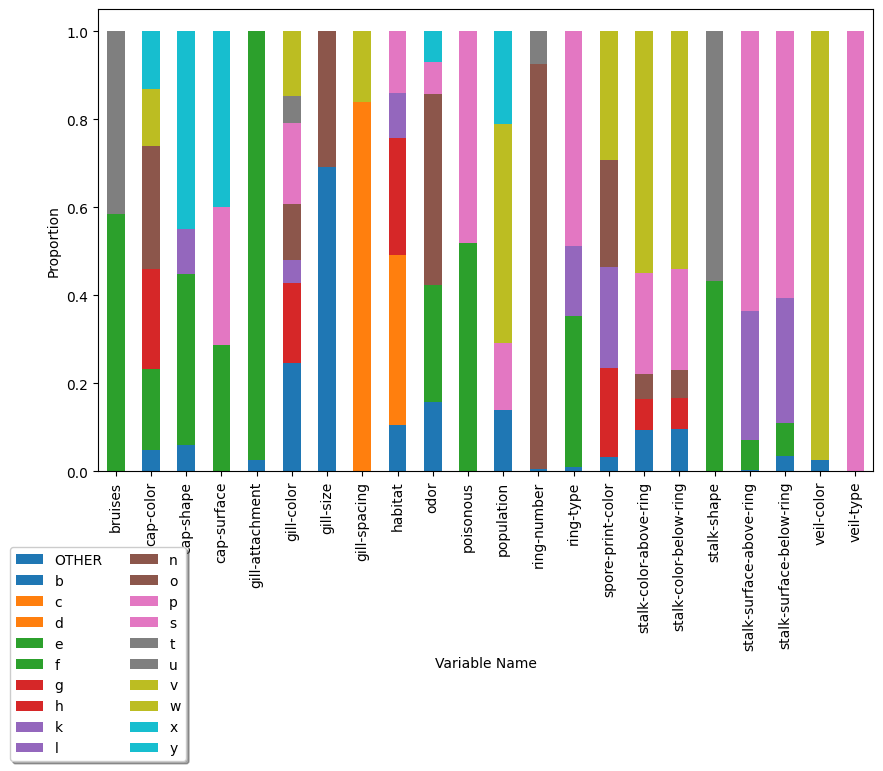

In [13]:
# plot of proportion of values in each variable
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))
plt.legend(loc='upper center', bbox_to_anchor=(0.0, -0.15), fancybox=True, shadow=True, ncol=2)
plt.xlabel("Variable Name")
plt.ylabel("Proportion")
plt.show()

In [14]:
high_freq_summary = pd.DataFrame(columns=['column', 'value', 'freq_pct'])

# Loop through each column
for column in df.columns:
    # Find the most common value and its frequency
    value = df[column].mode().iloc[0]
    freq_pct = df[column].value_counts(normalize=True).get(value, 0)
    
    # Append the results to the new DataFrame
    high_freq_summary = high_freq_summary._append({
        'column': column,
        'value': value,
        'freq_pct': freq_pct
    }, ignore_index=True)

high_freq_summary.sort_values('freq_pct', ascending=False).head()

,column,value,freq_pct
14,veil-type,p,1.000000
15,veil-color,w,0.975382
5,gill-attachment,f,0.974151
16,ring-number,o,0.921713
6,gill-spacing,c,0.838503


In [15]:
# identify columns that are over the 95% threshold
high_freq_thresh = .97

cols_to_drop = high_freq_summary[high_freq_summary['freq_pct'] >= freq_pct]['column']

In this step, I first visualized the frequency of each value within a column. This was to get an understanding if there are any features that are extremely homegenous, and thus would offer little help in modeling. 

To identify the columns to remove I iterated through each column, identify the mode, and identify how frequent the mode value appears for that column.

If the frequency is above 97% I drop that column as there is little variation and unlikely to have predicive power later on. In this case, I drop "veil-type", "veil-color", and "gill-attachment".

# Exploratory Data Analysis

#### 1. Target Distributions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


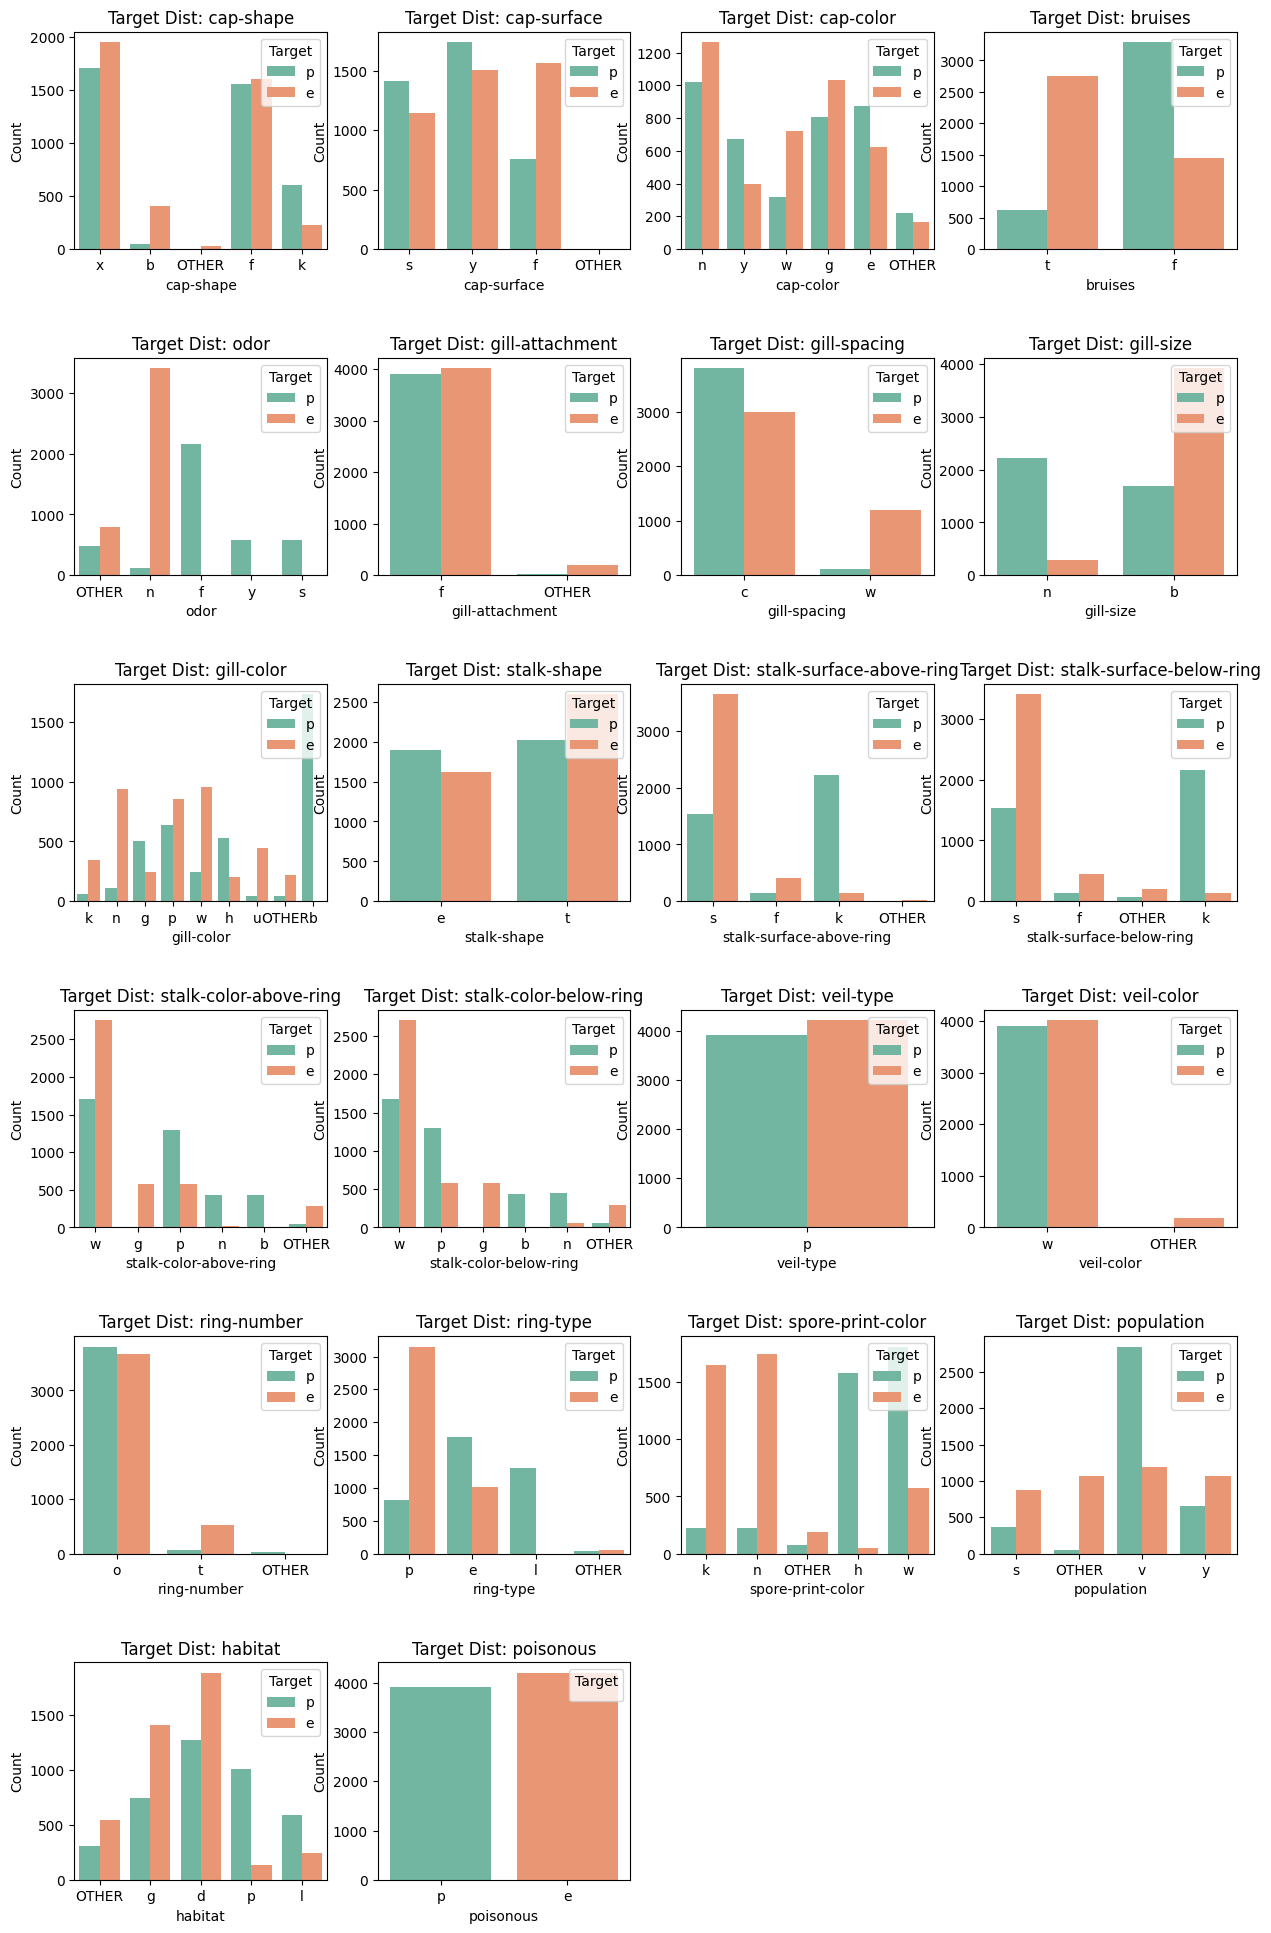

In [16]:
categorical_columns = df.select_dtypes(include=['object']).columns

num_cols = 4

# Calculate the number of rows needed based on the number of features
num_rows = len(categorical_columns) // num_cols + (len(categorical_columns) % num_cols > 0)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 4 * num_rows))
fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots

# Loop through each categorical feature and create stacked bar plots
for i, cat_col in enumerate(categorical_columns):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]

    sns.countplot(x=cat_col, hue='poisonous', data=df, palette='Set2', ax=ax)
    ax.set_title(f'Target Dist: {cat_col}')
    ax.set_xlabel(cat_col)
    ax.set_ylabel('Count')
    ax.legend(title='Target', loc='upper right')

# Hide empty subplots in case the number of subplots is not a perfect square
for i in range(len(categorical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

plt.show()

In this step of EDA, I look at the distribution of the target (poisinous) by each feature. The idea is that if there are any instances where a given features values that are frequently classified in a particular class they could be highly influential in model building.

Some features that stand out in that sense are habitat, ring-type, spore-print-color, stalk-surface-above-ring, stalk-surface-below-ring and bruises as they have values in which one of the classes is the dominant outcome.

Contrastly, a features such as veil-type has values in which the target is evenly distributed is unlikely to provide much explanatory power.

#### 2. Statistical Tests

In [17]:
# Get a list of categorical features
categorical_columns = df.select_dtypes(include=['object']).columns

# Create an empty DataFrame to store the results
chi2_results = pd.DataFrame(columns=['Feature', 'Chi2', 'P-value'])

# Loop through each categorical feature and perform Chi-Square test
for feature in categorical_columns:
    contingency_table = pd.crosstab(df[feature], df['poisonous'])
    chi2_stat, p_val, _, _ = chi2_contingency(contingency_table)
    chi2_results = chi2_results._append({'Feature': feature, 'Chi2': chi2_stat, 'P-value': p_val}, ignore_index=True)

# which results are insignificant?
print(chi2_results[chi2_results['P-value'] > .1])

cols_to_drop = chi2_results[chi2_results['P-value'] > .1]['Feature']

df=df.drop(columns=cols_to_drop)

      Feature  Chi2  P-value
14  veil-type   0.0      1.0


In this step look at which features are statstically significant in explaining the target variable using chi-squre tests.

I remove veil-type because it has a p-value over .1. However, I am leaving the rest of the variables, despite not not appearing to be influential, as the test show they have some explanatory power.

# Models

#### 1. Using FLAML for Model Selection and Hyperparameter Tuning 

In [18]:
# creating training and tests sets
X = df.drop(columns='poisonous',axis=1)
y = df['poisonous']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
le = LabelEncoder()

for column in X_train.select_dtypes(include=['object']).columns:
    X_train[column] = le.fit_transform(X_train[column])
    X_test[column] = le.transform(X_test[column])

In [20]:
# creating auto ML instance for a classification tests: looking at random forests, xgboost,  and logistic regression
automl = AutoML(task='classification', estimator_list=['rf', 'xgboost',  'lrl1'], time_budget=60)

# Run FLAML
automl.fit(X_train=X_train, y_train=y_train, X_val=X_test, y_val=y_test)

[flaml.automl.logger: 02-22 07:18:17] {1679} INFO - task = classification
[flaml.automl.logger: 02-22 07:18:17] {1687} INFO - Data split method: stratified
[flaml.automl.logger: 02-22 07:18:17] {1690} INFO - Evaluation method: holdout
[flaml.automl.logger: 02-22 07:18:17] {1788} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 02-22 07:18:17] {1900} INFO - List of ML learners in AutoML Run: ['rf', 'xgboost', 'lrl1']
[flaml.automl.logger: 02-22 07:18:17] {2218} INFO - iteration 0, current learner rf
[flaml.automl.logger: 02-22 07:18:17] {2344} INFO - Estimated sufficient time budget=532s. Estimated necessary time budget=4s.
[flaml.automl.logger: 02-22 07:18:17] {2391} INFO -  at 0.1s,	estimator rf's best error=0.0536,	best estimator rf's best error=0.0536
[flaml.automl.logger: 02-22 07:18:17] {2218} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 02-22 07:18:17] {2391} INFO -  at 0.1s,	estimator xgboost's best error=0.0153,	best estimator xgboost's best 

In [21]:
# best model
best_model = automl.model 
print(best_model)

In [22]:
# best parameters
best_params = automl.best_config
print(best_params)

{'n_estimators': 8, 'max_leaves': 10, 'min_child_weight': 2.98336806762758, 'learning_rate': 1.0, 'subsample': 1.0, 'colsample_bylevel': 0.9490667620045917, 'colsample_bytree': 0.6423120548801455, 'reg_alpha': 0.0023084514764154162, 'reg_lambda': 7.754214575857651}


In this section I use FLAML (Fast Lightweight Auto Machine Learning) to compare models, select the best model, and tune hyperparameters.

I first specified the models I wanted to try for this problem, including random forest, logistic regression, and XGBoost. The prevailing model was XGBoost, which while not covered in class, is a tree based algorithm that uses boosting.

One of the advantages of FLAML is that it automatically provides the best hyperparmaters, so no additional tuning is needed. However, if you were to use XGBoost on its own, you could still use FLAML to give hyperparmater tuning estimates.

#### 2. Prediction

In [23]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

# change classes to e or p
replace_values = np.where(y_pred == 0, 0, 1)
y_pred = replace_values.astype(str)

y_pred[y_pred=='0'] = 'e'
y_pred[y_pred=='1'] = 'p'

In this section I call predict on the "best model" from the FLAML results, which in this case is a XGBoost Classifier. Under the results and analysis section I will do a deep dive on the results.

# Results and Analysis

#### 1. Precision, Accuracy, Recall

In [27]:
# precision, accuracy, recall
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy is {accuracy}.")

# Precision
precision = precision_score(y_test, y_pred, pos_label='p')
print(f"precision is {precision}.")

# Recall
recall = recall_score(y_test, y_pred, pos_label='p')
print(f"recall is {recall}.")

accuracy is 1.0.
precision is 1.0.
recall is 1.0.


In this section I look at the precision, recall, and accuracy. In this case, being able to classify each mushroom as edible or poisinous was relatively straightforward given the attributes provided so I achieved an accuracy, precision, and recall of 100%. 

Typically, there is some tradeoff between precision and recall which would be important in this context. We are considering being poisonous to be the positive class in this case (labeled as 1). Given that knowledge, we would have wanted to maximize recall, to capture all possible mushrooms that could be poisinous, at the sacrifice precision. This is due to the consequences of mislabeling an edible mushroom as poisonous is relatively low, as you would not be able to eat the mushroom. On the contrary, labeling a poisonous mushroom as edible could have devastating consequences.

#### 2. Confusion Matrix

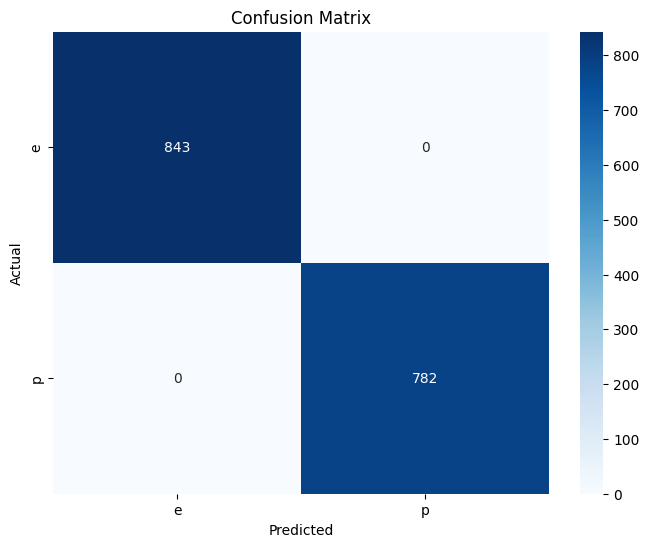

In [28]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In this section I plot a confusion matrix. This shows how the predicted class aligns with the actual class which can be a helpful visualization for stakeholders to digest the results of a classification problem.

#### 3. Feature Importance

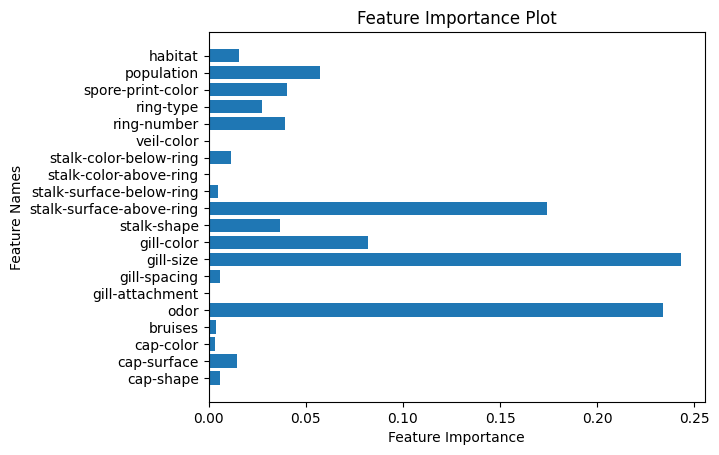

In [34]:
# Get feature importance
feature_importance = automl.model.estimator.feature_importances_

# Plot feature importance
feature_names = X_train.columns  # Assuming X_train is a DataFrame
plt.barh(feature_names, feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Feature Importance Plot')
plt.show()

In this section, I plot the feature importance of the model. In this case the gill-size and odor are the most influential features in predicting whether a mushroom is poisonous or edible.

If you are ever out in the woods, determining the gill-size and odor of a mushroom could be your best bet in determining if a mushroom is edible.

# Discussion and Conclusion

This project was a great opportunity to apply some learnings from class along with existing knowledge to tackle a fun problem relevant to my hobbies. Most notably this project was beneficial in the use of visualizations to understand potential explanatory variables and evaluate model results.

Given the limitations of the features, there was limited room for feature engineering. However, in future applications of supervised machine learning I would like to explore more feature engineering. Additionally, in an instance where I was struggling to achieve a successful precision/recall number, I could use additional hyperparmaeter tuning frameworks such as Optuna for additional model tuning.

While I tried logistic regression, random forest, and XGBoost, a more complex problem may require a deep learning approach such as a neural network. 